In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge



In [4]:
boston = load_boston()
X, y = boston['data'], boston['target']

In [7]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      


Признаки:

    CRIM - количество преступлений на душу населения
    ZN - процент жилых участков площадью больше 25 тыс. кв. футов (~ 23 сотки)
    INDUS - процент площадей под оптовую торговлю
    CHAS - протекает ли река
    NOX - концентрация оксидов азота
    RM - среднее число комнат в здании
    AGE - доля зданий, построенных до 1940 года
    DIS - взвешенное расстояние до 5 деловых центров Бостона
    RAD - индекс доступности скоростных магистралей
    TAX - уровень налогов
    PTRATIO - среднее число учащихся на одного преподавателя
    B - процент афроамериканцев
    LSTAT - процент граждан с низким уровнем жизни
    MEDV (целевой) - медианная стоимости домов в районе



In [12]:
y[:2]

array([ 24. ,  21.6])

In [8]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='<U7')


Lasso-регрессия

Lasso-регрессия решает задачу минимизации среднеквардатичной ошибки с L1-регуляризацией: $$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d |w_i|$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

Обучим Lasso-регрессию с небольшим коэффициентом $\alpha$ (слабая регуляризация). Обнуляется только коэффициент при признаке NOX (концентрация оксидов азота). Значит, он наименее важен для предсказания целевого признака – медианной стоимости домов в районе.


In [9]:
lasso = Lasso(alpha=0.1)
lasso.fit(X,y)
lasso.coef_

array([-0.09678792,  0.04917922, -0.03642541,  0.95709698, -0.        ,
        3.69894259, -0.01000634, -1.16012114,  0.27411189, -0.01456675,
       -0.77100252,  0.01032665, -0.56950927])

Обучим Lasso-регрессию с коэффициентом $\alpha=10$. Теперь ненулевые коэффициенты остались только при признаках ZN (процент жилых участков площадью больше 25 тыс. кв. футов), TAX (уровень налогов), B (процент афроамериканцев) и LSTAT (процент граждан с низким уровнем жизни).

In [10]:
lasso = Lasso(alpha=10)
lasso.fit(X,y)
lasso.coef_

array([-0.        ,  0.02614601, -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.00928243,
       -0.        ,  0.00749584, -0.56403798])

###  Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации.

In [17]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)

In [18]:
lasso_cv = LassoCV(alphas=alphas, cv=3, random_state=17)
lasso_cv.fit(X, y)



LassoCV(alphas=array([  0.1    ,   0.14975, ...,   9.95025,  10.     ]),
    copy_X=True, cv=3, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=17, selection='cyclic', tol=0.0001,
    verbose=False)

In [19]:
lasso_cv.coef_

array([-0.09633634,  0.04943349, -0.02730583,  0.16245012, -0.        ,
        3.55546459, -0.00723939, -1.13353947,  0.28039514, -0.0150312 ,
       -0.78020119,  0.01032709, -0.58332373])

In [20]:
lasso_cv.alpha_

0.14974874371859298

### Метод cross_val_score максимизирует метрику, так что вместо минимизации MSE сделаем максимизацию отрицательного MSE – neg_mean_squared_error.

In [21]:
cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, 
                scoring='neg_mean_squared_error')

array([-16.90196564, -37.60029071, -72.42092752])

### Чтобы все-таки трактовать результат в терминах MSE, выведем модуль среднего значения метрики neg_mean_squared_error на кросс-валидации.

In [22]:
abs(np.mean(cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, 
                        scoring='neg_mean_squared_error')))

42.30772795343924

In [23]:
abs(np.mean(cross_val_score(Lasso(9.95), X, y, cv=3 , scoring='neg_mean_squared_error')))

53.722668480656033

### Еще один неоднозначный момент: LassoCV сортирует значения параметров по убыванию – так проще оптимизировать. Из-за этого может показаться, что оптимизация параметра $\alpha$ работает неправильно

In [27]:
lasso_cv.alphas[:10] # значения параметров на входе

array([ 0.1       ,  0.14974874,  0.19949749,  0.24924623,  0.29899497,
        0.34874372,  0.39849246,  0.44824121,  0.49798995,  0.54773869])

In [28]:
lasso_cv.alphas_[:10] # преобразованные значения параметров

array([ 10.        ,   9.95025126,   9.90050251,   9.85075377,
         9.80100503,   9.75125628,   9.70150754,   9.65175879,
         9.60201005,   9.55226131])

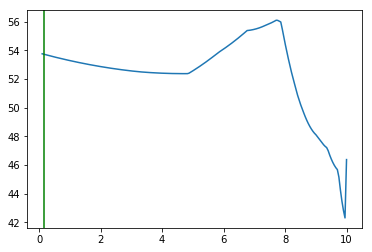

In [29]:
plt.plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1)) # неверно
plt.axvline(lasso_cv.alpha_, c='g');

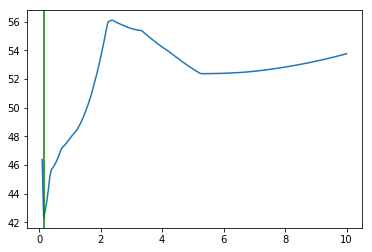

In [30]:
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1)) # верно
plt.axvline(lasso_cv.alpha_, c='g');


## Ridge-регрессия

Ridge-регрессия (или гребневая регрессия) решает задачу минимизации среднеквардатичной ошибки с L2-регуляризацией: $$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d w_i^2$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

В sklearn реализован специальный класс RidgeCV для кросс-валидации с Ridge-регрессией.


In [31]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

In [32]:
ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

RidgeCV(alphas=array([  1.00000e-02,   1.09699e-02, ...,   9.11589e+05,   1.00000e+06]),
    cv=3, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [33]:
ridge_cv.alpha_

264.30814869741084

### В случае Ridge-регрессии никакие праметры не зануляются – они могут быть очень малыми, но не нулевыми.

In [34]:
ridge_cv.coef_

array([-0.0992728 ,  0.05560678, -0.04988281,  0.30212213, -0.09167075,
        1.42147115,  0.01290084, -0.99854933,  0.33047941, -0.01661163,
       -0.82006053,  0.00883866, -0.72358474])